In [2]:
!pip install -U scikit-learn
!pip install autograd

  Using cached scikit_learn-1.5.2-cp312-cp312-macosx_10_9_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-macosx_10_9_x86_64.whl (12.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1


## Preliminary: the softmax function

The softmax function plays a crucial role in neural networks, particularly in the output layer of classification models. Its primary purpose is to convert a vector of real numbers into a probability distribution over multiple classes.

$$\text{Softmax}(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K
 $$

First, each element of the input vector is exponentiated (raised to the power of $e$), which makes all values positive.  The exponentiation step amplifies the differences between the input values. Larger values get significantly larger, and smaller values remain relatively small. This emphasizes the model's confidence in its predictions.

After exponentiation, the softmax function normalizes the values by dividing each exponentiated value by the sum of all exponentiated values in the input vector. This step ensures that the output vector sums up to 1, making it a valid probability distribution.

# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the following 2-class dataset:

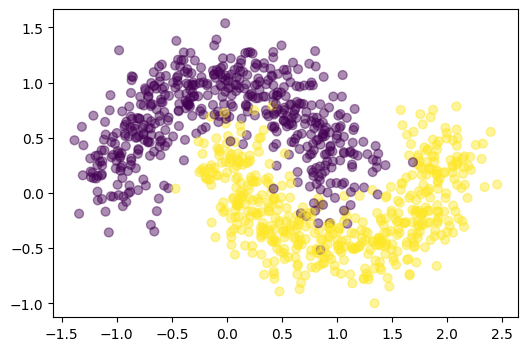

In [20]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a training dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20) #1000 total points generated, 0.2 standard deviation of Gaussian noise
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45) #s specifies marker size, c is color

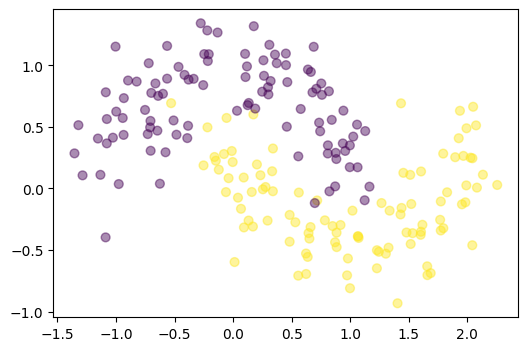

In [21]:
# Generate a testing dataset and plot it
np.random.seed(0)
Xt, yt = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(Xt[:,0], Xt[:,1], s=40, c=yt, alpha=0.45)

In [5]:
X[1], X.shape

(array([1.80460944, 0.00695963]), (1000, 2))

In [6]:
y[1], y.shape

(np.int64(1), (1000,))

## Classification

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer.

+ The number of nodes in the input layer will be determined by the dimensionality of our data (2).
+ Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2).

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ \hat{y} = \text{Softmax}({z_2})$$

where $\hat{y}$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network.

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$.


## Cross-entropy loss

A common choice with the softmax output is the **cross-entropy loss**.

If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [22]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters
epsilon = 0.01 # learning rate for gradient descent

In [8]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)

    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [9]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):

    # Initialize the parameters to random values.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    '''print('W1: ',W1.shape)
    print('b1: ',b1.shape)
    print('W2: ',W2.shape)
    print('b2: ',b2.shape)'''

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        #if print_loss and i % 1000 == 0:
            #print("Loss after iteration %i: %f" %(i, loss(model)))

    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)
print(model)

{'W1': array([[ 4.13653991, -1.387449  ,  1.33128157],
       [ 1.05827264,  1.09765998, -0.93394278]]), 'b1': array([[-2.24988389,  1.73950124,  0.63439646]]), 'W2': array([[ 3.33416265, -2.87301497],
       [ 2.95119694, -2.77373122],
       [-3.44211995,  4.36490874]]), 'b2': array([[ 0.29825758, -0.29825758]])}


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

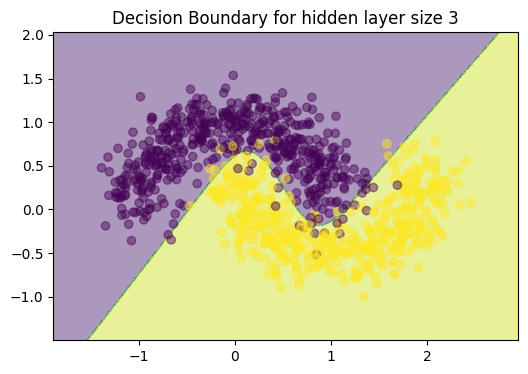

In [10]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)


# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

+ Report the classification accuracy using the testing dataset.

In [11]:
# your code here

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

#scale them
'''scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Xt_scaled = scaler.transform(Xt)'''

#predict using the model we created and the scaled test set
yhat = predict(model,Xt)

#check accuracy btwn test and prediction
metrics.accuracy_score(yt,yhat)



0.955

# Exercise 2

+ Add an additional layer to your neural network model.
+ Change the activation function and use a ReLU.
+ Report the classification accuracy using the testing dataset.


In [23]:
# your code here

num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

def relu(x):
	return np.maximum(0, x) #activation function

# Gradient descent parameters
epsilon = 0.01 # learning rate for gradient descent

# loss function for a 4-layer MLP
def loss(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)

    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x,W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [24]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):

    # Initialize the parameters to random values.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))

    '''print('W1: ',W1.shape)
    print('b1: ',b1.shape)
    print('W2: ',W2.shape)
    print('b2: ',b2.shape)
    print('W3: ',W3.shape)
    print('b3: ',b3.shape)'''

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        #if print_loss and i % 1000 == 0:
            #print("Loss after iteration %i: %f" %(i, loss(model)))

    return model

# Build a model with a 4-dimensional hidden layer
model = build_model(3, print_loss=True)
print(model)

{'W1': array([[ 2.29920065, -0.48725083,  1.4844892 ],
       [ 0.28120499,  0.8894043 , -0.10585227]]), 'b1': array([[0.46207501, 1.32250154, 1.39701216]]), 'W2': array([[-0.35533741, -0.39051515,  1.24317054],
       [-0.06229368,  0.03289838,  1.31019577],
       [ 1.63279644,  0.53485829, -0.72244938]]), 'b2': array([[0.14901015, 0.08031467, 0.33041891]]), 'W3': array([[-0.58868466,  1.64393857],
       [-0.45430472,  0.51660627],
       [ 0.35802169, -2.32510345]]), 'b3': array([[-0.17648444,  0.17648444]])}


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

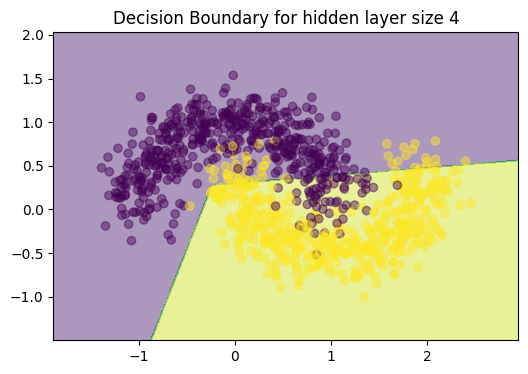

In [25]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)


# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 4")

In [26]:

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

#train and test datasets
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
Xt, yt = sklearn.datasets.make_moons(200, noise=0.20)

#scale them
'''scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Xt_scaled = scaler.transform(Xt)'''

#predict using the model we created and the scaled test set
yhat = predict(model,Xt)

#check accuracy btwn test and prediction
metrics.accuracy_score(yt,yhat)


0.875

Maybe multiple layers is too complex for such a simple model.

When I added an extra node and and extra hidden layer though, the accuracy was better 

# Exercise 3

+ Design your own model (number of layers, activation function, number of units per layer, etc.) and train it to classify the following dataset. The objective is to get a **smooth** decision boundary (it will generalize better than a non-smooth one).
+ Train the model and report the classification accuracy using the testing dataset.


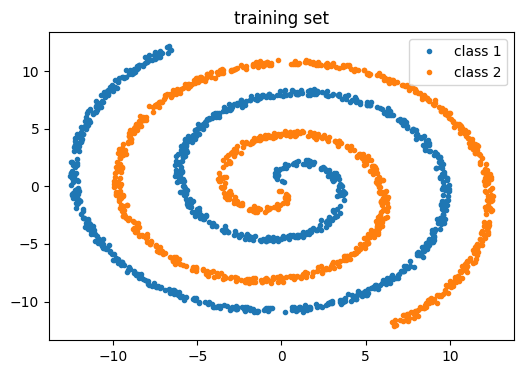

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten


def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    # Stack the two spirals together (mirrored for the second spiral)
    X = np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y))))
    
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

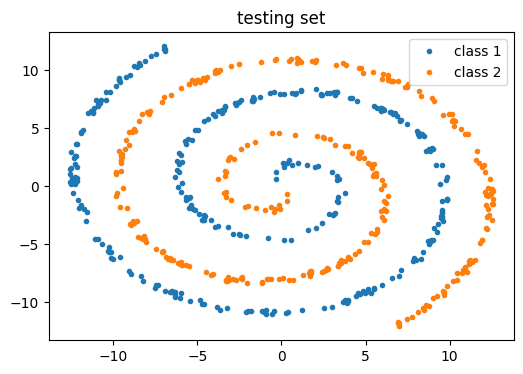

In [28]:
Xt, yt = twospirals(300)

plt.title('testing set')
plt.plot(Xt[yt==0,0], Xt[yt==0,1], '.', label='class 1')
plt.plot(Xt[yt==1,0], Xt[yt==1,1], '.', label='class 2')
plt.legend()
plt.show()





In [30]:
# your code here
import autograd.numpy as np

num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
def relu(x):
	return np.maximum(0, x) #activation function

# Gradient descent parameters
epsilon = 0.1 # learning rate for gradient descent
# loss function for a 4-layer MLP
def loss(model, X, y, lambda_reg=0.001):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    y_int = np.array(y, dtype=int)

    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y_int])
    data_loss = np.sum(corect_logprobs)

    l2_loss = lambda_reg * (np.sum(W1**2) + np.sum(W2**2) + np.sum(W3**2)) 

    return 1./num_examples * data_loss + l2_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

    z1 = np.dot(x,W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False, lambda_reg=0.001):

    # Initialize the parameters to random values.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_hdim))
    #W4 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    #b4 = np.zeros((1, nn_output_dim))
    '''print('W1: ',W1.shape)
    print('b1: ',b1.shape)
    print('W2: ',W2.shape)
    print('b2: ',b2.shape)'''

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD
        gradient_loss = grad(loss)(model, X, y, lambda_reg=lambda_reg)
    
        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss)
        grad_flat = np.clip(grad_flat, -1, 1)

        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        #if print_loss and i % 1000 == 0:
            #print("Loss after iteration %i: %f" %(i, loss(model, X, y, lambda_reg=lambda_reg)))

    return model


# Build a model with a 4-dimensional hidden layer (2 hidden layers)
model = build_model(20, print_loss=True)
print(model)

{'W1': array([[ 0.03163144,  0.79363457,  0.04387365,  0.34284347,  0.40757773,
        -0.90453776,  0.41532664,  0.34017616, -0.37235868, -0.04314673,
         0.35161975,  1.03953136, -0.736862  , -0.27120312, -0.08761332,
         0.77302648,  0.81243351, -1.02601412,  0.36297772, -0.49155315],
       [-0.85085027,  0.05979544,  0.11736424, -0.55703473,  0.59742462,
        -0.56486857, -0.76638851,  0.20608188,  0.80934504,  0.87466256,
         0.99275064, -0.50021724, -0.23045645, -0.74444895, -0.82382371,
        -0.08440066,  0.68413835,  0.25156898, -0.4557703 ,  0.36794926]]), 'b1': array([[-1.03595335, -1.91733894, -0.51242306, -0.63528311,  0.89973265,
        -2.06612656, -3.34177485,  8.51618402, -1.04404079, -1.06733408,
        -1.46265054, -3.88494798,  1.49265884, -1.02544298, -3.4107025 ,
        -2.23839076, -2.06306359, -3.20447685,  3.74995093, -1.46746038]]), 'W2': array([[ 2.86829831e-03,  1.32070994e-02, -3.62452392e-01,
         6.90554950e-02, -2.75935727e-0

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

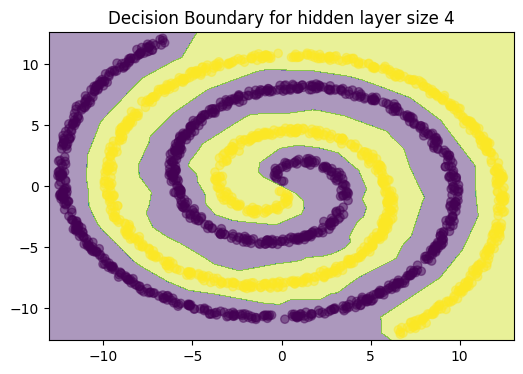

In [31]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)


# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 4")

Adding L2 regularization to the loss function really helped decrease the loss and make the model more accurate. Adding more nodes to the hidden layers helped the most. 

In [32]:

from sklearn import metrics
from sklearn.preprocessing import StandardScaler


#predict using the model we created and the scaled test set
yhat = predict(model,Xt)

#check accuracy btwn test and prediction
metrics.accuracy_score(yt,yhat)




1.0

A little bit of overfitting maybe...